# Set up

In [63]:
# Libraries
import gurobipy as grb
from gurobipy import GRB, quicksum
import matplotlib.pyplot as plt
model = grb.Model("Model")

# Decision variables

In [64]:
# Add decision variables
# We take the same notation that the "elements de solution folder"
p = 5     # nb de personnel
n = 5     # nb de projet
q = 3     # nb de qualification
h = 12    # horizon temporel, nb de jour de projets

# Données personnelles
Q = [ [0,1], [2], [0], [1], [0,1,2]] #competences par personne
V = [ [0, 5, 8], [], [], [], []] #congés par personne

# Données des projets
G =  [10, 10, 10, 10, 10] #gain par projet
P =  [1, 1, 1, 1, 1] #penalite par projet
# nombre de jours par compétence par projet / ex : le projet 2 necessite 7 jours de travail sur la compétance C
C = [[4,3,2],[3,2,7],[4,1,5],[3,3,3],[1,1,4]] 
D = [3,5,8,9,11] # Deadline

# Variables
X = model.addVars(p, n, q, h, vtype=GRB.BINARY)     
Y = model.addVars(n, vtype=GRB.BINARY)  # Le projet est-il complété en fin d'horizon temporel ?
L = model.addVars(n, vtype=GRB.INTEGER) # Jours de retard de chaque projets
E = model.addVars(n, vtype=GRB.INTEGER) # Date de fin effective de realisation du projet

# Constraints

In [65]:
# Add constraints

no_ubiquity = []
for i in range(p):
    for t in range(h):
        no_ubiquity += [model.addConstr(sum(X[i, j, k, t] for j in range(n) for k in range(q)) <= 1)]

no_forced_work = []
for i in range(p):
    for t in V[i]:
        no_forced_work += [model.addConstr(sum(X[i, j, k, t] for j in range(n) for k in range(q)) == 0)]

end_of_poject = []
for j in range(n):
    for k in range(q):
        if C[j][k] > 0:
            end_of_poject += [model.addConstr( Y[j] * C[j][k] <= sum(X[i, j, k, t] for i in range(p) for t in range(h)))]

skill_constr = []
for i in range(p):
    for j in range(n):
        for k in range(q):
            for t in range(h):
                if (k not in Q[i]) or (C[j][k] == 0) :
                    skill_constr += [model.addConstr(X[i,j,k,t] == 0)]

no_overwork = []
for j in range(n):
    for k in range(q):
        no_overwork += [model.addConstr(sum(X[i, j, k, t] for i in range(p) for t in range(h)) <= C[j][k])]

model.addConstrs((X[i,j,k,t] * t <= E[j] for i in range(p) for j in range(n) for k in range(q) for t in range(h)))

model.addConstrs((E[j] - D[j] <= L[j] for j in range(n)))

model.update()

# Variables and Constraints  for multi criteria decision

#### Project duration 

In [66]:
B = model.addVars(n, vtype=GRB.INTEGER)   # Begining dates
E = model.addVars(n, vtype=GRB.INTEGER)   # End dates

model.addConstrs(
    B[j] <= X[i, j, k, t] * t + (1 - X[i, j, k, t]) * h
    for i in range(p)
    for j in range(n) 
    for k in range(q)
    for t in range(h)    
)

model.addConstrs(
    E[j] >= X[i, j, k, t] * t 
    for i in range(p)
    for j in range(n) 
    for k in range(q)
    for t in range(h)    
)

model.update()

#### Number of project for people

In [67]:
R = model.addVars(p,n, vtype=GRB.BINARY)   # p a participé au projet n ?

for i in range(p):
    for j in range(n) :
        for k in range(q) :
            for t in range(h):
                model.addConstr(R[i,j] >= X[i, j, k, t] )

model.update()

#### get criteria value

In [68]:
def get_profit():
    return sum(Y[j].x * G[j] - L[j].x * P[j] for j in range(n))

def get_avg_project_duration():
    return sum(E[j].x - B[j].x for j in range(n)) / n

def get_avg_projects_per_person():
    return sum(R[i,j].x for i in range(p) for j in range(n)) / p 

# Optimization

### Optimization with various preferences in criteria 

In [69]:
# alpha va de 0.1 à 10
alpha = 0        # Va de de 0 à 1 
nb_points = 10
profits = []
avg_durations = []
avg_ppps = []

gain_obj = quicksum(Y[j] * G[j] - L[j] * P[j] for j in range(n))
duration_obj = quicksum(E[j] - B[j] for j in range(n))
project_per_person_obj = quicksum(R[i,j] for i in range(p) for j in range(n))

for alpha in range(nb_points):
    alpha = alpha / (nb_points -1)

    # Nous donnaons beaucoup de valeur au gain car nous estimons que c'est le critère le plus important
    # Voyons l'impact des poids attribués aux critères sur la durée et le nombre de personnes par projet
    
    model.setObjective(10 * gain_obj - alpha * duration_obj - (1-alpha) * project_per_person_obj , GRB.MAXIMIZE)
    model.optimize()

    profits.append(get_profit())
    avg_durations.append(get_avg_project_duration())
    avg_ppps.append(get_avg_projects_per_person())

print("\nOptimal objective value: ", round(model.ObjVal,0))

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 4118 rows, 950 columns and 10240 nonzeros
Model fingerprint: 0xa1e26e37
Variable types: 0 continuous, 950 integer (930 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [1e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective -0.0000000
Presolve removed 3659 rows and 466 columns
Presolve time: 0.08s
Presolved: 459 rows, 484 columns, 2357 nonzeros
Variable types: 0 continuous, 484 integer (480 binary)

Root relaxation: objective 4.903125e+02, 895 iterations, 0.05 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  490.31250    0  109   -0.00000  490.31250      -     -    0s
H    0     0                     195.0000000  49

#### Dominance graph

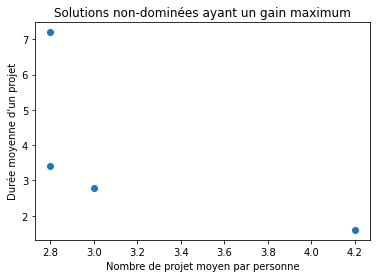

In [79]:
# Pour l'exmple du cours et nos critères, il n'y a que 4 solutions non dominées :
critere1 = [2.8, 2.8, 3.0, 4.2] 
critere2 = [7.2, 3.4, 2.8, 1.6]

plt.scatter(avg_durations, avg_ppps)
plt.title("Solutions non-dominées ayant un gain maximum")
plt.xlabel("Nombre de projet moyen par personne")
plt.ylabel("Durée moyenne d'un projet")
plt.show()

# Categorisation of a given planning (Ne fonctionne pas pour l'instant)

In [ ]:
def get_profit_d():
    return sum(Y[j] * G[j] - L[j] * P[j] for j in range(n))

def get_avg_project_duration_d(X):
    return sum(E[j] - B[j] for j in range(n)) / n

def get_avg_projects_per_person_d(X):
    return sum(R[i,j] for i in range(p) for j in range(n)) / p   

In [59]:
X_decideur = [ X[i,j,k,t].x for i in range(p) for j in range(n) for k in range(q) for t in range(h) ]

def planning_categorisation(X_decideur):

    profit_d = get_profit_d(X_decideur)
    avg_duration_d = get_avg_project_duration_d(X_decideur)
    avg_ppp_d = get_avg_projects_per_person_d(X_decideur)

    if profit_d == max(profits):
        for k in range(nb_points):
            if avg_durations[k] < avg_duration_d:
                if avg_ppps[k] < avg_ppp_d:
                    print("Planning inacceptable car dominé par le point : ", k)
                    return 2
        print("Planning est satisfaisant")
        return 0
    for k in range(nb_points):
        if avg_durations[k] <= avg_duration_d:
            if avg_ppps[k] <= avg_ppp_d:
                print("Planning inacceptable car dominé par le point : ", k)
                return 2
    print("Planning correct car n'est pas dominé, cepandant son gain n'est pas maximum")
    return 1



In [60]:
def show_X_decideur_on_domination_graph(X_decideur, categorisation = ""):
    profit_d = get_profit(X_decideur)
    avg_duration_d = get_avg_project_duration(X_decideur)
    avg_ppp_d = get_avg_projects_per_person(X_decideur)

    plt.scatter(avg_durations, avg_ppps)
    plt.scatter(avg_duration_d, avg_ppp_d)
    plt.xlabel("Nombre de projet moyen par personne")
    plt.ylabel("Durée moyenne d'un projet")
    plt.show()
        

# Affichage du planning

#### Affichage par personne

In [61]:
for i in range(p):
    jours_travaille = 0
    print("\nEmploi du temps personne ",i, " : ")
    for t in range(h):
        for k in range(q):
            for j in range(n):
                if X[i,j,k,t].x != 0:
                    jours_travaille += 1
                    print("Jour ", t, " Compétence ", k, " sur projet ", j)
    print("Jours travailés : ", jours_travaille)


Emploi du temps personne  0  : 
Jour  1  Compétence  1  sur projet  0
Jour  2  Compétence  1  sur projet  1
Jour  3  Compétence  1  sur projet  1
Jour  6  Compétence  1  sur projet  2
Jour  7  Compétence  0  sur projet  2
Jour  9  Compétence  0  sur projet  3
Jour  10  Compétence  1  sur projet  4
Jour  11  Compétence  0  sur projet  4
Jours travailés :  8

Emploi du temps personne  1  : 
Jour  0  Compétence  2  sur projet  0
Jour  1  Compétence  2  sur projet  0
Jour  2  Compétence  2  sur projet  1
Jour  3  Compétence  2  sur projet  1
Jour  4  Compétence  2  sur projet  1
Jour  5  Compétence  2  sur projet  2
Jour  6  Compétence  2  sur projet  2
Jour  7  Compétence  2  sur projet  2
Jour  8  Compétence  2  sur projet  3
Jour  9  Compétence  2  sur projet  3
Jour  10  Compétence  2  sur projet  4
Jour  11  Compétence  2  sur projet  4
Jours travailés :  12

Emploi du temps personne  2  : 
Jour  0  Compétence  0  sur projet  0
Jour  1  Compétence  0  sur projet  0
Jour  2  Compétenc

#### Affichage par projet

In [62]:
for j in range(n):
    print("\nAllocation pour le projet ",j, " : ")
    print("Durée du projet : ", E[j].x - B[j].x )
    for k in range(q):
        for i in range(p):
            for t in range(h):
                if X[i,j,k,t].x != 0:
                    print(" Compétence ", k, " par personne ", i, " Jour ", t)

print("Durée moyenne des projets : ", sum(E[j].x - B[j].x for j in range(n)) / n)


Allocation pour le projet  0  : 
Durée du projet :  1.0
 Compétence  0  par personne  2  Jour  0
 Compétence  0  par personne  2  Jour  1
 Compétence  0  par personne  4  Jour  0
 Compétence  0  par personne  4  Jour  1
 Compétence  1  par personne  0  Jour  1
 Compétence  1  par personne  3  Jour  0
 Compétence  1  par personne  3  Jour  1
 Compétence  2  par personne  1  Jour  0
 Compétence  2  par personne  1  Jour  1

Allocation pour le projet  1  : 
Durée du projet :  3.0
 Compétence  0  par personne  2  Jour  2
 Compétence  0  par personne  2  Jour  3
 Compétence  0  par personne  2  Jour  4
 Compétence  1  par personne  0  Jour  2
 Compétence  1  par personne  0  Jour  3
 Compétence  2  par personne  1  Jour  2
 Compétence  2  par personne  1  Jour  3
 Compétence  2  par personne  1  Jour  4
 Compétence  2  par personne  4  Jour  2
 Compétence  2  par personne  4  Jour  3
 Compétence  2  par personne  4  Jour  4
 Compétence  2  par personne  4  Jour  5

Allocation pour le proje

# Annexe

In [141]:
model.setObjectiveN(quicksum(Y[j] * G[j] - L[j] * P[j] for j in range(n)), 0, 1)
model.setObjectiveN(- quicksum(E[j] - B[j] for j in range(n)), 1, 0)
model.ModelSense = GRB.MAXIMIZE
model.update()
model.optimize()